In [1]:
import autoray
from importlib import reload
import qubit_networks as beeky
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer
import exact_jwt
import functools 
import matplotlib.pyplot as plt

def tf_qr(x):
    U, s, VH = autoray.do('linalg.svd', x)
    
    dtype = autoray.get_dtype_name(U)
    if 'complex' in dtype:
        s = autoray.astype(s, dtype)
    
    Q = U
    R = autoray.reshape(s, (-1, 1)) * VH
    
    return Q, R


autoray.register_function('tensorflow', 'linalg.qr', tf_qr)

In [2]:

LX, LY = 2, 3
T_PARAM=1
V_PARAM=2
MU_PARAM=0.6
DTYPE = 'complex128'

autodiff_backend = 'tensorflow'
autodiff_backend_opts = {'experimental_compile': True}

def state_energy(
    psi: beeky.QubitEncodeVector,
    hterms: dict,
    vterms: dict,
    **opts):
    '''Energy <psi|H|psi>, summing contributions from
    horiz/vertical terms in Hamiltonian.
    '''

    # TODO: compute row/col envs first?
    he = psi.compute_local_expectation(
        hterms, normalized=True, **opts)

    ve = psi.compute_local_expectation(
        vterms, normalized=True, **opts)        
    
    return autoray.do('real', (he + ve))

def state_stability(
    psi: beeky.QubitEncodeVector,
    stab_terms: dict,
    **opts):
    ''' *Negative* expectation value of the stabilizers, i.e.
    -1 for code-space overlap and +1 for complement.
    -1 * <Stab>
    '''
    # return autoray.do('real', psi.compute_local_expectation(stab_terms, normalized=True, **opts))
    bra = psi.H
    E = 0
    for (where, G) in stab_terms.items():
        G_ket = psi.apply_gate(G, where)
        E += (bra|G_ket)^all
    
    norm = psi.make_norm()^all
    return E/norm




In [3]:
reload(exact_jwt)

analytical = exact_jwt.HubbardSpinless(LX, LY)
analytical.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
Hexact = analytical._Ham.copy()
gex, gsx = qu.eigh(Hexact)
gse_exact = gex[0]
print(f'(Lx={LX}, Ly={LY}) -- GSE EXACT: {gse_exact}')


(Lx=2, Ly=3) -- GSE EXACT: -4.2611818771749626


In [4]:

Hsim = beeky.SpinlessSimHam(Lx=LX, Ly=LY, t=T_PARAM, V=V_PARAM, mu=MU_PARAM) #qubit Hamiltonian

Hstab = beeky.HamStab(Lx=LX, Ly=LY) #stabilizer terms

Hmaster = beeky.MasterHam(Hsim, Hstab) #combine HSim + Hstab

net1 = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=2)
net2 = net1.copy()
net3 = net1.copy()

comp_fns = {'stab' : functools.partial(beeky.compute_encnet_ham_expec, ham = Hstab), 
'norm':beeky.compute_encnet_normsquared,
'sim': functools.partial(beeky.compute_encnet_ham_expec, ham=Hsim) }

#master evolve
tebd1 = beeky.iTimeTEBD(net1, ham=Hmaster, compute_every=50, compute_extra_fns=comp_fns)

#sim evolve
tebd2 = beeky.iTimeTEBD(net2, ham=Hsim, compute_every=50, compute_extra_fns=comp_fns)

tebd3 = beeky.iTimeTEBD(net3, ham=Hstab, compute_every=50, compute_extra_fns=comp_fns)


n=450, tau=0.01, energy~-1.000000: 100%|██████████| 500/500 [00:01<00:00, 461.65it/s]


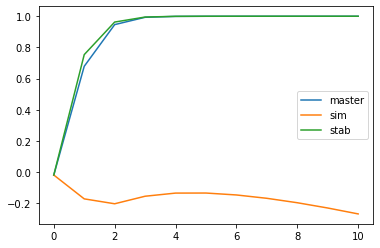

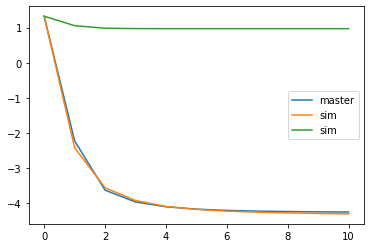

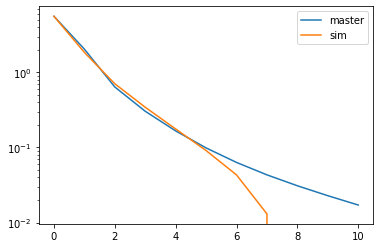

In [11]:
# tebd1.evolve(500)
# tebd2.evolve(500)
# tebd3.evolve(500)

plt.plot(-tebd1.get_final_data('Estab'), label='master')
plt.plot(-tebd2.get_final_data('Estab'), label='sim')
plt.plot(-tebd3.get_final_data('Estab'), label='stab')
plt.legend()
plt.show()

plt.plot(tebd1.get_final_data('Esim'), label='master')
plt.plot(tebd2.get_final_data('Esim'), label='sim')
plt.plot(tebd3.get_final_data('Esim'), label='sim')
plt.legend()
plt.show()

plt.semilogy((tebd1.get_final_data('Esim'))-gse_exact, label='master')
plt.semilogy((tebd2.get_final_data('Esim'))-gse_exact, label='sim')
plt.legend()
plt.show()

In [5]:
reload(beeky)

HubSimHam = Hsim
Hstab = Hstab
Hmaster = Hmaster

horizontal_terms = dict(HubSimHam.gen_horizontal_ham_terms())
vertical_terms = dict(HubSimHam.gen_vertical_ham_terms())

stab_terms = dict(Hstab.gen_ham_terms())

compute_expec_opts = dict(
                cutoff=0.0, 
                max_bond=9, 
                contract_optimize='random-greedy')

psi0 = beeky.QubitEncodeVector.rand(Lx=LX, Ly=LY, bond_dim=2, dtype=DTYPE)
psi0.setup_bmps_contraction_()

    
optmzr = TNOptimizer(
    psi0, # initial state guess
    loss_fn=state_energy,
    constant_tags=['AUX',],
    loss_constants={'hterms': horizontal_terms,
                    'vterms': vertical_terms},
    loss_kwargs=compute_expec_opts,
    autodiff_backend=autodiff_backend,
    **autodiff_backend_opts)



In [10]:
E0 = state_energy(psi0, horizontal_terms, vertical_terms)
print(f'INITIAL: {E0}')

tn_opt = optmzr.optimize(100)
print("OPTIMIZED: ", state_energy(tn_opt, horizontal_terms, vertical_terms))

print(f"EXACT: {gse_exact}")



  0%|          | 0/100 [01:18<?, ?it/s]
OPTIMIZED:  -0.40225209117637356
EXACT: -4.2611818771749626


In [46]:
# optm_stab = TNOptimizer(
#     psi0,
#     loss_fn=state_stability,
#     constant_tags=['AUX',],
#     loss_constants={'stab_terms': stab_terms},
#     loss_kwargs=compute_expec_opts,
#     autodiff_backend=autodiff_backend,
#     **autodiff_backend_opts)


# expec_stab_0 = psi0.compute_ham_expec(Hstab)
# print(f'STAB0: {expec_stab_0}')

tn_opt = optm_stab.optimize(100)
tn_opt.compute_ham_expec(Hstab)

(-0.034261708115787666-2.829645657797654e-19j)